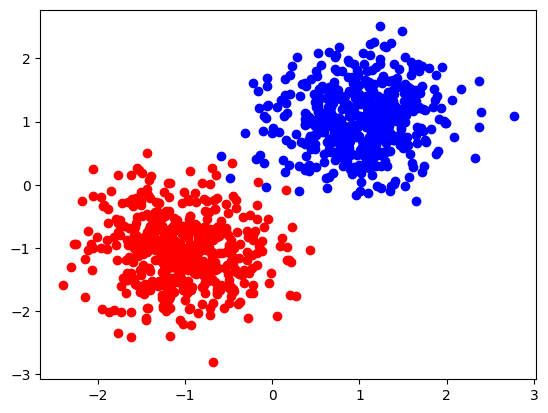

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from jax import random

scale = 0.5
start = -1
amount = 500
data = np.concatenate((
np.hstack((
    np.vstack(np.random.normal(start, scale, amount)),
    np.vstack(np.random.normal(start, scale, amount))
    )),
np.hstack((
    np.vstack(np.random.normal(start+2, scale, amount)),
    np.vstack(np.random.normal(start+2, scale, amount))
    ))
    ))

plt.scatter(data[:amount,0] ,data[:amount,1],color="r",label="first")
plt.scatter(data[amount:,0] ,data[amount:,1],color="b",label="second")


In [2]:
# def sigmoid(X):
#     return X * (X > 0)

def sigmoid(X):
    return 1./(1 + np.exp(-X))

def add_bias(X):
    return np.concatenate([np.ones((X.shape[0],1)), X], axis=1)

jax_key = random.PRNGKey(0)

def one_layer_init(input_size, output_size):
    return random.uniform(key=jax_key, shape=(output_size, input_size + 1), minval=-3, maxval=3)

def compute_layer(A_j, Theta_j):
    z = np.dot(A_j, Theta_j.T)
    return sigmoid(z)

def n_layer_init(layer_sizes):
    weights = []
    for l_idx in range(len(layer_sizes)-1):
        weights.append( one_layer_init(input_size=layer_sizes[l_idx], output_size=layer_sizes[l_idx+1]) )
    return weights

def forward_prop(X, Thetas):
    A0 = add_bias(X)
    outputs = [A0]
    for theta in Thetas[:-1]:
        A = compute_layer(outputs[-1], theta)
        outputs.append( add_bias(A) )
    return outputs + [compute_layer(outputs[-1], Thetas[-1])]

def cost_function(A, Y):
    return -np.sum(Y * np.log(A) + (1-Y) * np.log(1-A))

def output_delta(A_j, Y):
    return A_j - Y

def weight_update(A_j, Delta_next, Theta_j, rate):
    return Theta_j - rate * np.dot(Delta_next.T, A_j)

def hidden_delta(A_j, Delta_next, Theta_j):
    return A_j * (1-A_j) * np.dot(Delta_next, Theta_j)

def optimization_objective(Thetas, X, Y):

    Y_hat = forward_prop(X, Thetas)[-1]
    return cost_function(Y_hat, Y)
from jax import grad

# Define a simple test function
def test_function(x, w, a=5):
    return np.dot(x**a, w)

# For comparison with Jax's output,
# we'll hard-code the test function's derivative
def my_derivative(x, w, a=5):
    # compute df/dx the hard way, by hand
    return a * x**(a-1) * w

# auto-diff magic!
# All you have to do is call grad(func_to_diff),
# passing in the function that you want to
# differentiate (func_to_diff) as the argument.
# Jax will then compute the derivative w.r.t.
# the *first argument* of func_to_diff(x, y, z).
# So jax will return a function for d_func_to_diff/d_x:
jax_derivative = grad(test_function)






In [3]:
def one_layer_training(X, Y, Thetas, iters=250, rate=0.9):
    cost_per_iter = []

    for i in range(iters):

        A = forward_prop(X, Thetas)

        delta = output_delta(A[-1], Y)
        Thetas[-1] = weight_update(A[-2], delta, Thetas[-1], rate=rate)

        cost_per_iter.append(cost_function(A[-1], Y))

    plt.figure(figsize=(7,5))
    plt.plot([x+1 for x in range(iters)], cost_per_iter, "-b")
    plt.xlabel("Training Iterations", fontsize=18)
    plt.ylabel("Cost Function", fontsize=18)
    plt.show()
    return Thetas

def two_layer_training(X, Y, Thetas, iters=500, rate=0.5):
    ### YOUR SOLUTION HERE
    cost_per_iter = []
    for i in range(iters):
        # compute hidden layers
        A = forward_prop(X, Thetas)

        # update Theta_1
        # GRADING NOTE: 1 pt here
        delta = output_delta(A[-1], Y)
        Thetas[-1] = weight_update(A[-2], delta, Thetas[-1], rate=rate)

        # update Theta_0
        # GRADING NOTE: 1 pt here
        delta = hidden_delta(A[-2], delta, Thetas[-1])
        # remove dimension corresponding to bias
        delta = delta[:, 1:]
        # GRADING NOTE: 1 pt here
        Thetas[-2] = weight_update(A[-3], delta, Thetas[-2], rate=rate)

        # track loss
        cost_per_iter.append(cost_function(A[-1], Y))

    plt.figure(figsize=(7,5))
    plt.plot([x+1 for x in range(iters)], cost_per_iter, "-b")
    plt.xlabel("Training Iterations", fontsize=18)
    plt.ylabel("Cost Function", fontsize=18)
    plt.show()

    return Thetas
objective_grad = grad(optimization_objective)
def jax_training(X, Y, Thetas, iters=500, rate=0.5):
    cost_per_iter = []
    for i in range(iters):
        ### YOUR SOLUTION HERE
        # GRADING NOTE: 1 pt here
        # Get the Theta gradients using Jax
        theta_grads = objective_grad(Thetas, X, Y)

        # Loop through the gradients and make updates to Thetas
        # GRADING NOTE: 1 pt here
        for idx, t_grad in enumerate(theta_grads):
            Thetas[idx] = Thetas[idx] - rate * t_grad

        # track cost function
        cost_per_iter.append(cost_function(forward_prop(X, Thetas)[-1], Y))

    # plot cost per iteration
    plt.figure(figsize=(7,5))
    plt.plot([x+1 for x in range(iters)], cost_per_iter, "-b")
    plt.xlabel("Training Iterations", fontsize=18)
    plt.ylabel("Cost Function", fontsize=18)
    plt.show()

    return Thetas


C:\Users\Rex\AppData\Local\Temp\ipykernel_10512\3097146046.py:5: RuntimeWarning: overflow encountered in exp
  return 1./(1 + np.exp(-X))
C:\Users\Rex\AppData\Local\Temp\ipykernel_10512\3097146046.py:34: RuntimeWarning: divide by zero encountered in log
  return -np.sum(Y * np.log(A) + (1-Y) * np.log(1-A))
C:\Users\Rex\AppData\Local\Temp\ipykernel_10512\3097146046.py:34: RuntimeWarning: invalid value encountered in multiply
  return -np.sum(Y * np.log(A) + (1-Y) * np.log(1-A))


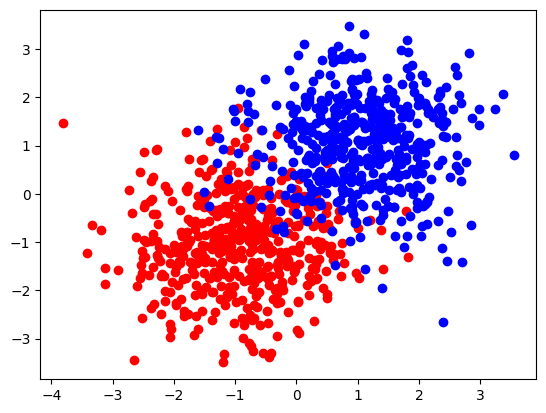

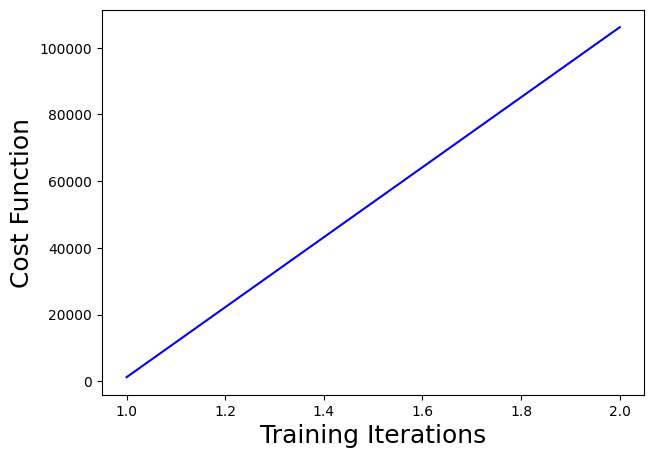

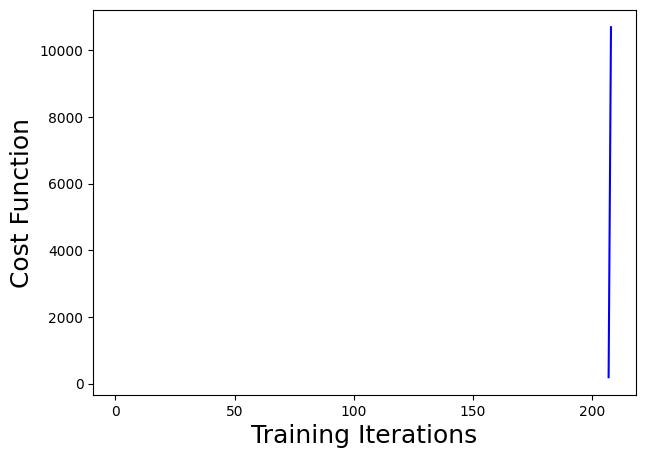

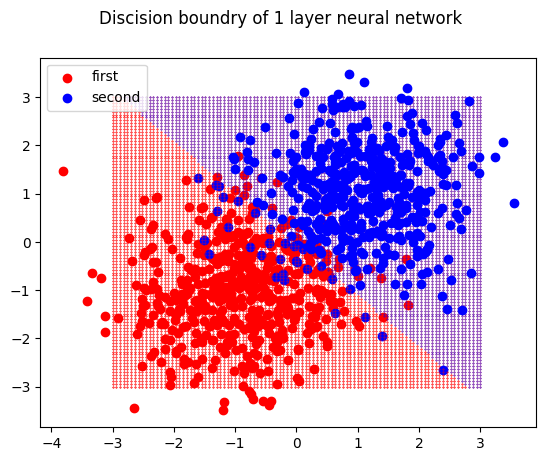

Text(0.5, 0.98, 'Discision boundry of 2 layer neural network')

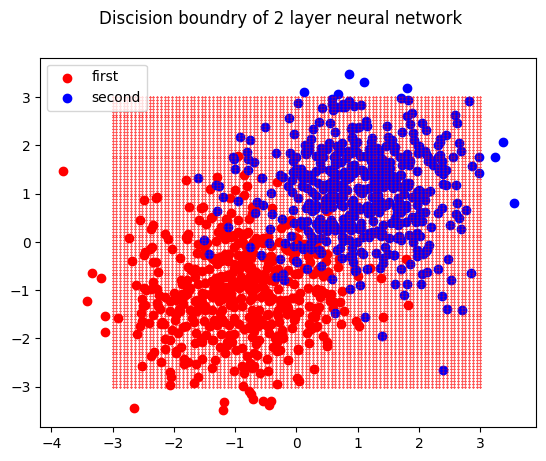

In [4]:
scale = 0.9
start = -1
amount = 500
data = np.concatenate((
np.hstack((
    np.vstack(np.random.normal(start, scale, amount)),
    np.vstack(np.random.normal(start, scale, amount))
    )),
np.hstack((
    np.vstack(np.random.normal(start+2, scale, amount)),
    np.vstack(np.random.normal(start+2, scale, amount))
    ))
    ))

plt.scatter(data[:amount,0] ,data[:amount,1],color="r",label="first")
plt.scatter(data[amount:,0] ,data[amount:,1],color="b",label="second")


labels= np.hstack(([0]*amount,[1]*amount))

Theta_j_twolayer = two_layer_training(data, np.vstack(labels), Thetas=n_layer_init([2,3, 1]))

Theta_j_onelayer =one_layer_training(data, np.vstack(labels), Thetas=n_layer_init([2, 1]))


number_of_datapoints = 100
line = np.vstack(np.linspace(-3,3,number_of_datapoints))
fakedata = np.array([[0,0]])
for datapoint in line:
    
    fakedata=np.vstack((fakedata,np.hstack((line,np.vstack(np.linspace(datapoint,datapoint,number_of_datapoints))))))

plt.scatter(fakedata[:,0],fakedata[:,1],color="r",s=0.1)
idx0 = np.where(forward_prop(fakedata,Theta_j_onelayer)[1] <= 0.5)
idx1 = np.where(forward_prop(fakedata,Theta_j_onelayer)[1] > 0.5)


plt.scatter(data[:amount,0] ,data[:amount,1],color="r",label="first")


plt.scatter(data[amount:,0] ,data[amount:,1],color="b",label="second",)
plt.legend()

plt.scatter(fakedata[idx0,0],fakedata[idx0,1],color="r",s=0.1)
plt.scatter(fakedata[idx1,0],fakedata[idx1,1],color="b",s=0.1)
plt.suptitle("Discision boundry of 1 layer neural network")
plt.show()

plt.scatter(fakedata[:,0],fakedata[:,1],color="r",s=0.1)
idx0 = np.where(forward_prop(fakedata,Theta_j_twolayer)[-1] <= 0.5)
idx1 = np.where(forward_prop(fakedata,Theta_j_twolayer)[-1] > 0.5)


plt.scatter(data[:amount,0] ,data[:amount,1],color="r",label="first")


plt.scatter(data[amount:,0] ,data[amount:,1],color="b",label="second",)
plt.legend()

plt.scatter(fakedata[idx0,0],fakedata[idx0,1],color="r",s=0.1)
plt.scatter(fakedata[idx1,0],fakedata[idx1,1],color="b",s=0.1)
plt.suptitle("Discision boundry of 2 layer neural network")



C:\Users\Rex\AppData\Local\Temp\ipykernel_10512\3097146046.py:34: RuntimeWarning: divide by zero encountered in log
  return -np.sum(Y * np.log(A) + (1-Y) * np.log(1-A))
C:\Users\Rex\AppData\Local\Temp\ipykernel_10512\3097146046.py:34: RuntimeWarning: invalid value encountered in multiply
  return -np.sum(Y * np.log(A) + (1-Y) * np.log(1-A))
C:\Users\Rex\AppData\Local\Temp\ipykernel_10512\3097146046.py:5: RuntimeWarning: overflow encountered in exp
  return 1./(1 + np.exp(-X))


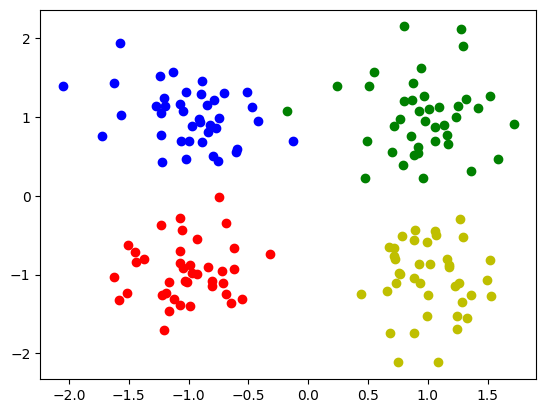

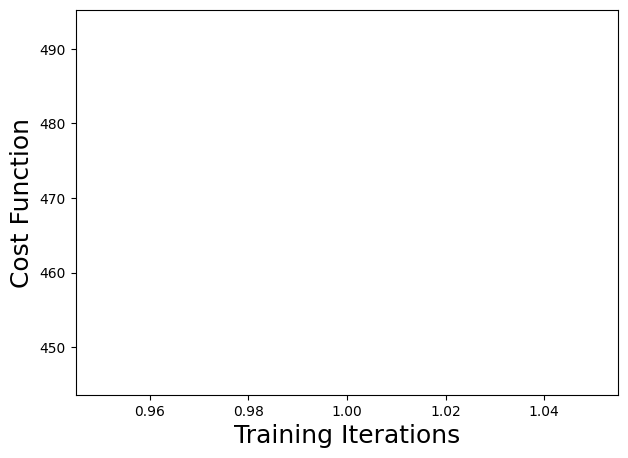

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0.5, 0.98, 'Discision boundry of 2 layer neural network')

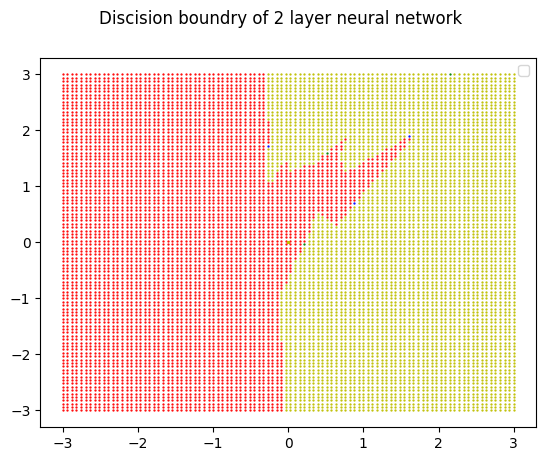

In [5]:
scale = 0.4
start = -1
amount = 40
data = np.concatenate((
np.hstack((
    np.vstack(np.random.normal(start, scale, amount)),
    np.vstack(np.random.normal(start, scale, amount))
    )),
np.hstack((
    np.vstack(np.random.normal(start, scale, amount)),
    np.vstack(np.random.normal(start+2, scale, amount))
    )),
np.hstack((
    np.vstack(np.random.normal(start+2, scale, amount)),
    np.vstack(np.random.normal(start+2, scale, amount))
    )),
np.hstack((
    np.vstack(np.random.normal(start+2, scale, amount)),
    np.vstack(np.random.normal(start, scale, amount))
    )),
    ))

plt.scatter(data[:amount,0] ,data[:amount,1],color="r",label="first")
plt.scatter(data[amount:2*amount,0] ,data[amount:2*amount,1],color="b",label="second")
plt.scatter(data[-2*amount:-amount,0] ,data[-2*amount:-amount,1],color="g",label="third")
plt.scatter(data[-amount:,0] ,data[-amount:,1],color="y",label="fourth")

labels= np.hstack(([0]*amount,[0.33]*amount,[0.66]*amount,[1]*amount))


Theta_j_twolayer = two_layer_training(data, np.vstack(labels), Thetas=n_layer_init([2,200, 1]))

idx0 = np.where(forward_prop(fakedata,Theta_j_twolayer)[-1] <= 0.25)
idx1 = np.where((0.50 > forward_prop( fakedata,Theta_j_twolayer)[-1]) & (forward_prop( fakedata,Theta_j_twolayer)[-1] >= 0.25))
idx2 = np.where((0.75 > forward_prop(fakedata,Theta_j_twolayer)[-1]) & (forward_prop( fakedata,Theta_j_twolayer)[-1] >= 0.50))
idx3 = np.where(forward_prop(fakedata,Theta_j_twolayer)[-1] >= 0.75)


# plt.scatter(data[:amount,0] ,data[:amount,1],color="r",label="first")
# plt.scatter(data[amount:2*amount,0] ,data[amount:2*amount,1],color="b",label="second")
# plt.scatter(data[-2*amount:-amount,0] ,data[-2*amount:-amount,1],color="g",label="third")
# plt.scatter(data[-amount:,0] ,data[-amount:,1],color="y",label="fourth")
plt.legend()

plt.scatter(fakedata[idx0,0],fakedata[idx0,1],color="r",s=0.4)
plt.scatter(fakedata[idx1,0],fakedata[idx1,1],color="b",s=0.4)
plt.scatter(fakedata[idx2,0],fakedata[idx2,1],color="g",s=0.4)
plt.scatter(fakedata[idx3,0],fakedata[idx3,1],color="y",s=0.4)

plt.suptitle("Discision boundry of 2 layer neural network")



C:\Users\Rex\AppData\Local\Temp\ipykernel_10512\3097146046.py:5: RuntimeWarning: overflow encountered in exp
  return 1./(1 + np.exp(-X))
C:\Users\Rex\AppData\Local\Temp\ipykernel_10512\3097146046.py:34: RuntimeWarning: divide by zero encountered in log
  return -np.sum(Y * np.log(A) + (1-Y) * np.log(1-A))
C:\Users\Rex\AppData\Local\Temp\ipykernel_10512\3097146046.py:34: RuntimeWarning: invalid value encountered in multiply
  return -np.sum(Y * np.log(A) + (1-Y) * np.log(1-A))


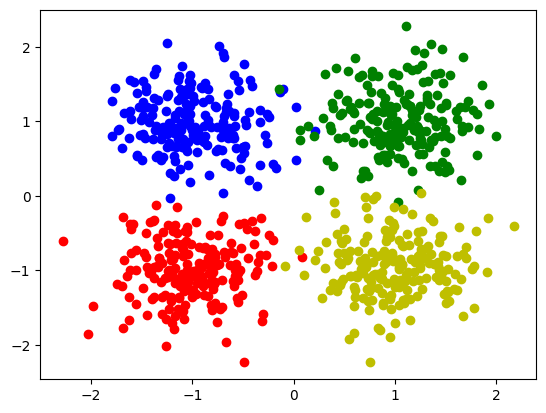

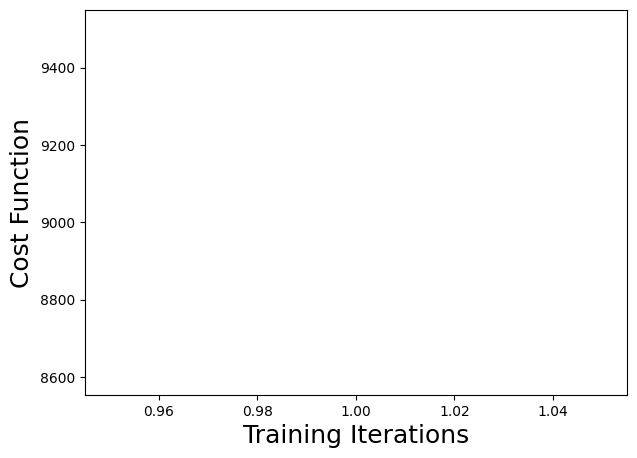

Text(0.5, 0.98, 'Discision boundry of 2 layer neural network')

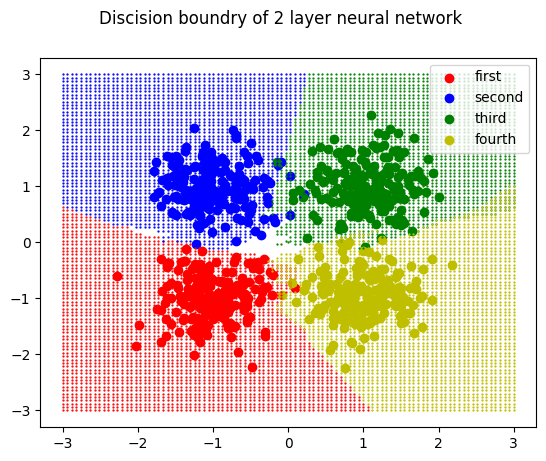

In [11]:
scale = 0.4
start = -1
amount = 200
data = np.concatenate((
np.hstack((
    np.vstack(np.random.normal(start, scale, amount)),
    np.vstack(np.random.normal(start, scale, amount))
    )),
np.hstack((
    np.vstack(np.random.normal(start, scale, amount)),
    np.vstack(np.random.normal(start+2, scale, amount))
    )),
np.hstack((
    np.vstack(np.random.normal(start+2, scale, amount)),
    np.vstack(np.random.normal(start+2, scale, amount))
    )),
np.hstack((
    np.vstack(np.random.normal(start+2, scale, amount)),
    np.vstack(np.random.normal(start, scale, amount))
    )),
    ))

plt.scatter(data[:amount,0] ,data[:amount,1],color="r",label="first")
plt.scatter(data[amount:2*amount,0] ,data[amount:2*amount,1],color="b",label="second")
plt.scatter(data[-2*amount:-amount,0] ,data[-2*amount:-amount,1],color="g",label="third")
plt.scatter(data[-amount:,0] ,data[-amount:,1],color="y",label="fourth")

labels= np.vstack(([[1,0,0,0]]*amount,[[0,1,0,0]]*amount,[[0,0,1,0]]*amount,[[0,0,0,1]]*amount))

Theta_j_twolayer = two_layer_training(data, labels, iters=2000, rate=0.9, Thetas=n_layer_init([2,200, 4]))
result  = forward_prop(fakedata,Theta_j_twolayer)
idx0 = np.where(result[-1][:,0] > 0.80)
idx1 = np.where(result[-1][:,1] > 0.80)
idx2 = np.where(result[-1][:,2] > 0.80)
idx3 = np.where(result[-1][:,3] > 0.80)


plt.scatter(data[:amount,0] ,data[:amount,1],color="r",label="first")
plt.scatter(data[amount:2*amount,0] ,data[amount:2*amount,1],color="b",label="second")
plt.scatter(data[-2*amount:-amount,0] ,data[-2*amount:-amount,1],color="g",label="third")
plt.scatter(data[-amount:,0] ,data[-amount:,1],color="y",label="fourth")
plt.legend()

plt.scatter(fakedata[idx0,0],fakedata[idx0,1],color="r",s=0.4)
plt.scatter(fakedata[idx1,0],fakedata[idx1,1],color="b",s=0.4)
plt.scatter(fakedata[idx2,0],fakedata[idx2,1],color="g",s=0.4)
plt.scatter(fakedata[idx3,0],fakedata[idx3,1],color="y",s=0.4)

plt.suptitle("Discision boundry of 2 layer neural network")
